In [1]:
import networkx as nx
import numpy as np

from matplotlib import pyplot as plt

import pennylane as qml

from pennylane import numpy as np

In [2]:
np.random.seed(50)

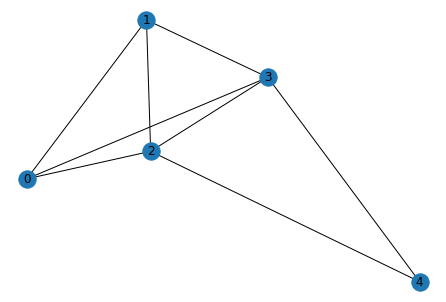

In [14]:
nr_nodes=5
n_wires = nr_nodes
graph = [(0,1,1.0),(1,2,9.0),(0,2,7.0),(3,1,5),(2,3,3.0),(0,3,1.0),(4,3,1),(4,2,1)]
G=nx.Graph()
G.add_weighted_edges_from(graph)
nx.draw(G,with_labels=True)

In [15]:
#brut force  for verification  :
def brut_MaxCut(graph,nr_nodes):
    
    W=np.zeros((int(nr_nodes),int(nr_nodes)))
    for i in graph:
        W[i[0]][i[1]]=i[2]
        W[i[1]][i[0]]=i[2]       


    best_cost_brute=0
    max_str=[]
    maxim=0
    for b in range(2**nr_nodes):
        x=[int(t) for t in reversed(list(bin(b)[2:].zfill(nr_nodes)))]
        cost=0
        for i in range(nr_nodes):
            for j in range(nr_nodes):
                cost=cost+W[i,j]*x[i]*(1-x[j])

        
        if best_cost_brute==cost:
            max_str.append(str(x))
            
        if best_cost_brute<cost:
            best_cost_brute=cost
            max_str=[]
            max_str.append(str(x))
 
            
    return  max_str, best_cost_brute
            
#Example:#      
max_str, best_cost= brut_MaxCut(graph,nr_nodes)  
print("Best cut (cost={}): \n ".format(best_cost))
for i in max_str:
    print(i)

Best cut (cost=24.0): 
 
[0, 0, 1, 1, 0]
[1, 1, 0, 0, 1]


In [28]:
def UB_01(beta,n_wires):
    for wire in range(n_wires):
        qml.RX(2 * beta, wires=wire)
        
def UC_01(gamma,graph):
    for edge in graph:
        
        wire1=edge[0]
        wire2=edge[1]
        w=edge[2]
        
        qml.CNOT(wires=[wire1, wire2])
        qml.RZ(-w*gamma, wires=wire2)
        qml.CNOT(wires=[wire1, wire2])
        
        
def Init_H(n_wires):
    for wire in range(n_wires):
        qml.Hadamard(wires=wire)

In [29]:
def comp_basis_measurement(wires):
    n_wires = len(wires)
    return qml.Hermitian(np.diag(range(2 ** n_wires)), wires=wires)

In [30]:
pauli_z = [[1, 0], [0, -1]]
pauli_z_2 = np.kron(pauli_z, pauli_z)

dev = qml.device("default.qubit", wires=n_wires, analytic=True, shots=1)

@qml.qnode(dev)
def circuit(gammas, betas,n_wires,graph, edge=None, l=1):

    Init_H(n_wires)
    
    for i in range(l):
        UC_01(gammas[i],graph)
        UB_01(betas[i],n_wires)
        
    if edge is None:
        return qml.sample(comp_basis_measurement(range(n_wires)))
    
    return qml.expval(qml.Hermitian(pauli_z_2, wires=(edge[0],edge[1])))  # 1 circuit for eatc edge ?? sems not very practical

In [41]:
# minimize the negative of the objective function
def objective(params,l,n_wires,graph,):
    gammas = params[0]
    betas = params[1]
    cost = 0
    for edge in graph:
        # objective for the MaxCut problem
        cost -= 0.5 * (1 - edge[2]*circuit(gammas, betas,n_wires=n_wires,graph=graph, edge=edge, l=l))
    return cost

In [42]:
def qaoa_maxcut(graph,n_wires,l=1,steps=30,n_samples = 100):
    print("\n number of layers ={:d}".format(l))

    # initialize the parameters near zero
    init_params = 0.01 * np.random.rand(2, 2)

    # initialize optimizer: Adagrad works well empirically
    opt = qml.AdagradOptimizer(stepsize=0.5)
    
    # optimize parameters in objective
    params = init_params
    for i in range(steps):
        params = opt.step(objective, params,n_wires=n_wires,graph=graph,l=l)
        if (i + 1) % 5 == 0:
            print("-Cost after step {:5d}: {: .7f}".format(i + 1, -objective(params,n_wires=n_wires,graph=graph,l=l)))

    bit_strings = []
    for i in range(0, n_samples):
        bit_strings.append(int(circuit(params[0], params[1], n_wires=n_wires,graph=graph, edge=None, l=l)))

    # print optimal parameters and most frequently sampled bitstring
    counts = np.bincount(np.array(bit_strings))
    most_freq_bit_string = np.argmax(counts)
    print("Optimized (gamma, beta) vectors:\n{}".format(params[:, :l]))
    print("Most frequently sampled bit string is: {:04b}".format(most_freq_bit_string))

    return -objective(params,n_wires=n_wires,graph=graph,l=l), bit_strings


# perform qaoa on our graph with p=1,2 and
# keep the bitstring sample lists
bitstrings1 = qaoa_maxcut(graph,nr_nodes,l=1,steps=100,n_samples = 100)[1]
bitstrings2 = qaoa_maxcut(graph,nr_nodes,l=2,steps=100,n_samples = 100)[1]


 number of layers =1
-Cost after step     5:  6.5726298
-Cost after step    10:  7.6847259
-Cost after step    15:  8.2579113
-Cost after step    20:  8.6092889
-Cost after step    25:  8.7279934
-Cost after step    30:  8.8242942
-Cost after step    35:  8.8602634
-Cost after step    40:  8.8818135
-Cost after step    45:  8.8909818
-Cost after step    50:  8.8958844
-Cost after step    55:  8.8981130
-Cost after step    60:  8.8992451
-Cost after step    65:  8.8997769
-Cost after step    70:  8.9000406
-Cost after step    75:  8.9001665
-Cost after step    80:  8.9002283
-Cost after step    85:  8.9002580
-Cost after step    90:  8.9002724
-Cost after step    95:  8.9002794
-Cost after step   100:  8.9002828
Optimized (gamma, beta) vectors:
[[-0.42495478]
 [ 0.88286541]]
Most frequently sampled bit string is: 0110

 number of layers =2
-Cost after step     5:  5.2683282
-Cost after step    10:  5.8818791
-Cost after step    15:  6.7105138
-Cost after step    20:  8.2727661
-Cost af

In [34]:
#Example:#      
max_str, best_cost= brut_MaxCut(graph,nr_nodes)  
print("Best cut (cost={}): \n ".format(best_cost))
for i in max_str:
    print(i)

Best cut (cost=24.0): 
 
[0, 0, 1, 1, 0]
[1, 1, 0, 0, 1]


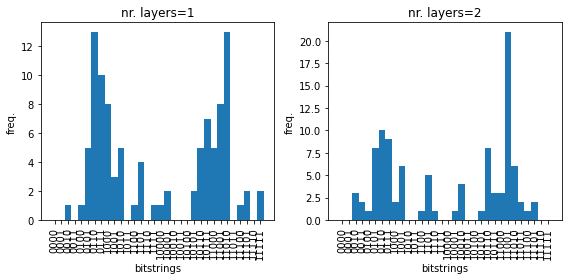

In [44]:
xticks = range(0, 2**nr_nodes)
xtick_labels = list(map(lambda x: format(x, "04b"), xticks))
bins = np.arange(0, 2**nr_nodes+1) - 0.5

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.title("nr. layers=1")
plt.xlabel("bitstrings")
plt.ylabel("freq.")
plt.xticks(xticks, xtick_labels, rotation="vertical")
plt.hist(bitstrings1, bins=bins)
plt.subplot(1, 2, 2)
plt.title("nr. layers=2")
plt.xlabel("bitstrings")
plt.ylabel("freq.")
plt.xticks(xticks, xtick_labels, rotation="vertical")
plt.hist(bitstrings2, bins=bins)
plt.tight_layout()
plt.show()